In [5]:
import os

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")
from nltk import FreqDist
import spacy

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import itertools
from nltk.tokenize import sent_tokenize
import re
import textstat
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


from utils import *

[nltk_data] Downloading package punkt to /Users/kevinxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kevinxu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/kevinxu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [52]:
path = 'rawdata/PC.tsv.gz'
raw_df = pd.read_csv(path,sep='\t', on_bad_lines='skip')

# 1 Preprocessing

In [53]:
# 1.1 only get total_votes >= 50
df = raw_df[raw_df['total_votes'] >= 40]

In [4]:
df.shape

(38814, 15)

In [5]:
df.columns.tolist()

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [6]:
df.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtype: object

In [7]:
# 1.2 Removing Nulls & duplicate
df.isnull().sum()
df = df.dropna()


In [8]:
# 1.3 Preparing columns
# review
df['review'] = df['review_headline'] + " " + df['review_body']
df=df.drop(['review_headline', 'review_body'], axis=1)
df = df.drop_duplicates(subset=['review'])

In [9]:
# review_date type
# df['review_date'] =  pd.to_datetime(df['unixReviewTime'],unit='s')

In [10]:
# vote ratio  => label
df['vote_ratio'] = df['helpful_votes'] / df['total_votes']
df=df.drop(['helpful_votes', 'total_votes'], axis=1)

In [11]:
threshold = 0.80
df['helpfulness'] = [1 if x >= threshold else 0 for x in df['vote_ratio']]

In [12]:
# verified purchase to 1 0
df['verified_purchase'] = [1 if x == 'Y' else 0 for x in df['verified_purchase']]

In [13]:
df.helpfulness.value_counts()

helpfulness
1    29479
0     9273
Name: count, dtype: int64

In [14]:
# verified purchase to 1 0
df['vine'] = [1 if x == 'Y' else 0 for x in df['vine']]

In [15]:
# sentence tokenize
df['sentence_count'] = df.apply(lambda row: sent_tokenize(row['review']), axis=1).apply(lambda x: len(x))

# 2 EDA

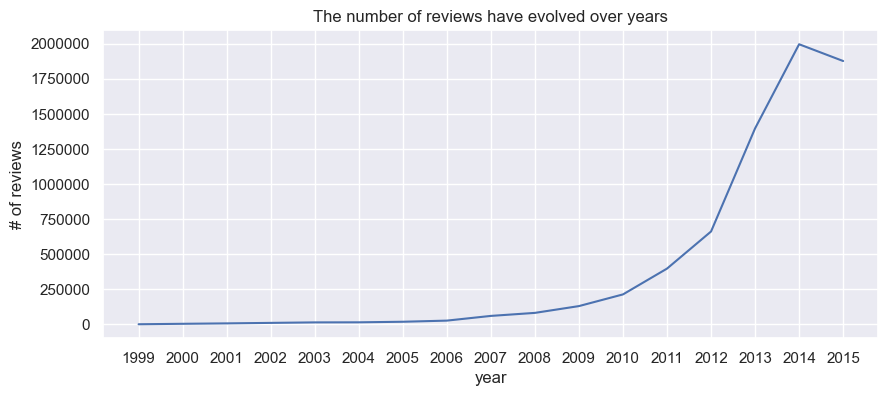

In [16]:
# 2.0 trending of reviews #
raw_df['year'] = pd.to_datetime(raw_df['review_date']).dt.year

sns.set(rc={'figure.figsize':(10,4)})
year_reviews = raw_df['year'].groupby(raw_df['year']).count().reset_index(name="# of reviews").sort_values(by=['# of reviews'], ascending=False)

ax = sns.lineplot(x="year", y="# of reviews", data=year_reviews)

ax.yaxis.get_major_formatter().set_scientific(False)
ax.set(xticks=year_reviews['year'].values)
plt.title('The number of reviews have evolved over years')
plt.show()

In [17]:
# 2.1.1 customers write most reviews
customer_reviews = raw_df['customer_id'].groupby(raw_df['customer_id']).count().reset_index(name="# of reviews").sort_values(by=['# of reviews'], ascending=False)
top10_customer = customer_reviews[:10]
top10_customer

,customer_id,# of reviews
1463359,17957446,458
3305704,44834233,442
4029462,52938899,366
3380402,45664110,275
3684497,49452274,261
3803234,50820654,256
825943,12200139,251
3327196,45070473,251
2433469,32038204,241
3669058,49266466,240


In [18]:
# 2.1.2 how the rating of  these top 10 customer distribute

top10_customerID = top10_customer['customer_id'].to_numpy()

top10_customer_ratings = raw_df[raw_df['customer_id'].isin(top10_customerID)][['customer_id', 'star_rating']]

top10_customer_ratings = top10_customer_ratings.groupby(["customer_id"], as_index=False).agg({'star_rating': [np.size, np.min, np.max, np.median, np.mean]})
top10_customer_ratings.columns = top10_customer_ratings.columns.droplevel(0)
top10_customer_ratings = top10_customer_ratings.sort_values(['size'],ascending=False).head(10)
top10_customer_ratings = top10_customer_ratings.rename(columns={ top10_customer_ratings.columns[0]: "customer_id" })
top10_customer_ratings = top10_customer_ratings.rename(columns={"size": "total_reviews"})
top10_customer_ratings

,customer_id,total_reviews,amin,amax,median,mean
1,17957446,458,1,5,5.0,4.676856
3,44834233,442,1,5,5.0,4.742081
9,52938899,366,1,5,5.0,4.341530
5,45664110,275,2,5,4.0,3.938182
7,49452274,261,1,5,5.0,4.482759
8,50820654,256,2,5,5.0,4.523438
0,12200139,251,1,5,5.0,4.808765
4,45070473,251,1,5,5.0,4.836653
2,32038204,241,1,5,5.0,4.585062
6,49266466,240,2,5,5.0,4.454167


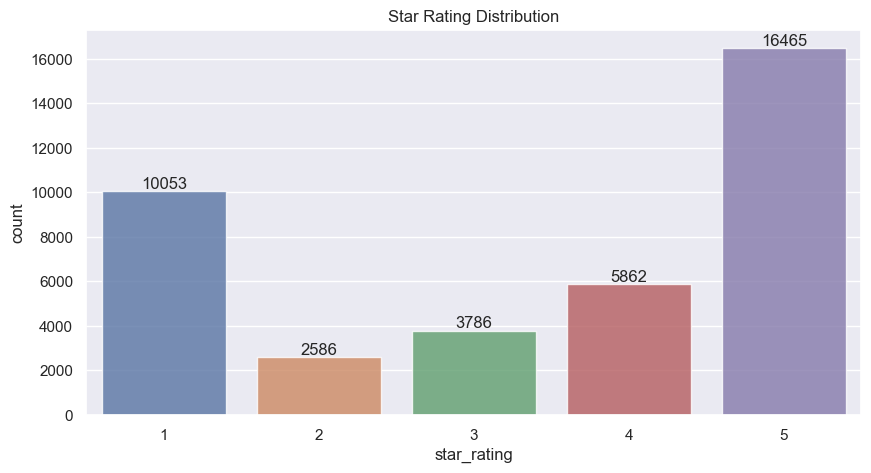

In [19]:
# 2.3.1 how total rating distribute
sns.set(rc={'figure.figsize':(10,5)})
ratings = df['star_rating'].groupby(df['star_rating']).count().reset_index(name="count")
ax = sns.barplot(data=ratings, x='star_rating', y='count', order=ratings['star_rating'], alpha=0.8)
ax.set(title='Star Rating Distribution')
ax.bar_label(ax.containers[0])

plt.show()

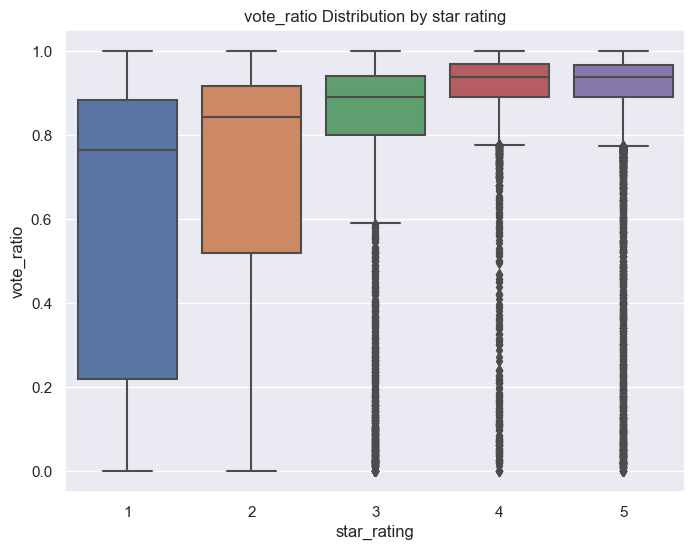

In [20]:
# 2.3.2 rating and vote_ratio     vote helpful
sns.set(rc={'figure.figsize':(8,6)})
rating_helpfulness = df[['star_rating', 'vote_ratio']]
ax = sns.boxplot(x="star_rating", y="vote_ratio", data=rating_helpfulness)
ax.set(title='vote_ratio Distribution by star rating')
plt.show()

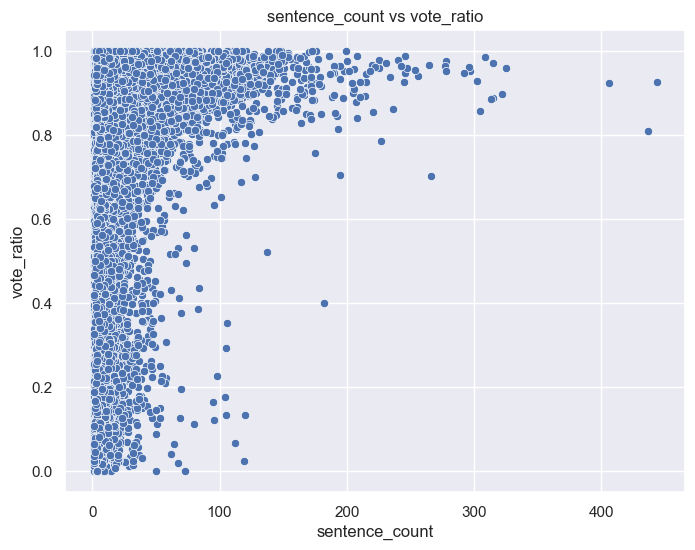

In [21]:
# 2.3.3 vote_ratio vs sentence_count
# pd.options.mode.chained_assignment = None

sentence_ratio = df[['sentence_count', 'vote_ratio']]

sns.set(rc={'figure.figsize':(8,6)})
ax = sns.scatterplot(data=sentence_ratio, x='sentence_count', y='vote_ratio')
ax.set(title='sentence_count vs vote_ratio')

plt.show()

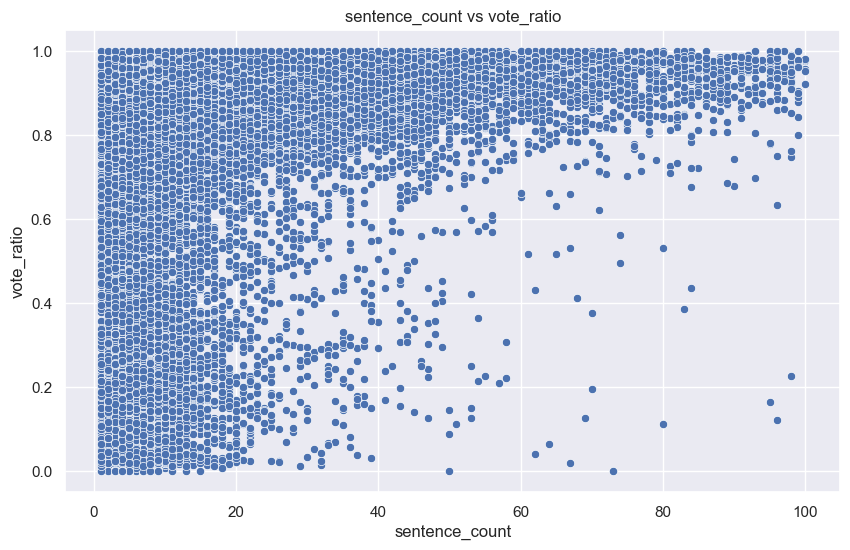

In [22]:
# 2.3.3.1 vote_ratio vs sentence_count < 1 to 100
sentence100_ratio = sentence_ratio[sentence_ratio['sentence_count'] <= 100]

sns.set(rc={'figure.figsize':(10,6)})
ax = sns.scatterplot(data=sentence100_ratio, x='sentence_count', y='vote_ratio')
ax.set(title='sentence_count vs vote_ratio')

plt.show()


In [23]:
# # Calculate Pearson coefficient of correlation
# data_for_corr = data.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Time',
#                            'HelpfulnessDenominator', 'Summary', 'Text'], 
#                           axis=1)

# data_for_corr.corr()
# # Visualize correlation coefficients as a heatmap
# sns.heatmap(data_for_corr.corr());

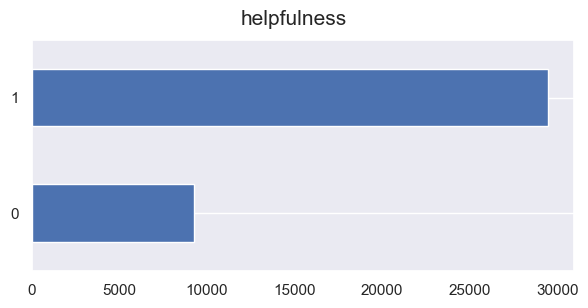

In [24]:
plot_distributions(df, x="helpfulness", top=None, figsize=(7,3))

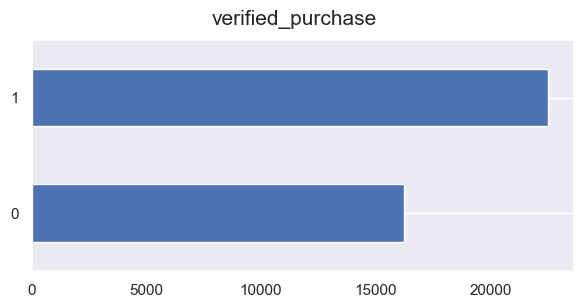

In [25]:
plot_distributions(df, x="verified_purchase", top=None, figsize=(7,3))

In [26]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'vine', 'verified_purchase', 'review_date', 'review', 'vote_ratio',
       'helpfulness', 'sentence_count'],
      dtype='object')

# 3 Text Preprocessing

Tokenizing

Removing stopwords

In [27]:
# word count
punct_remover = str.maketrans('','', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
## remove num with word, punctuaction, stopword
def extract_words(sentence):
    sentence_nodigits = re.sub("\d+", "", sentence)
    words = re.sub("[^\w]", " ",  sentence_nodigits).split()
    words_punct = [w.translate(punct_remover) for w in words]
    words_stop = [w for w in words_punct if w not in stopwords.words('english')]
    words_len = [word for word in words_stop if len(word) > 2]
    return words_punct

df['words'] = [extract_words(x) for x in df['review']]
df['word_count'] = [len(x) for x in df['words']]

In [28]:
# Automated Readability Index (ARI)
df['ARI'] = [textstat.automated_readability_index(x) for x in df['review']]

In [29]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,vine,verified_purchase,review_date,review,vote_ratio,helpfulness,sentence_count,words,word_count,ARI
414,US,48034474,R35OW0SJPJWAHO,B00JQZJ7YU,937857628,iXCC Silicon Case Cover for Apple iPad Mini,PC,1,0,1,2015-08-31,Cannot be used with headphones If you plan to ...,0.074074,0,4,"[Cannot, be, used, with, headphones, If, you, ...",61,7.5
939,US,38631333,RAP2ETU511BOI,B00J46VW9O,172187766,iXCC Black Lightning cable,PC,1,0,1,2015-08-31,Shorted out after 2 days use Worked for 2 days...,0.050505,0,2,"[Shorted, out, after, days, use, Worked, for, ...",45,11.7
1112,US,37757447,R1S9O5CCTD61ZD,B00QR2CY6S,819547817,Fusion4K High Speed 4K HDMI Cable - Profession...,PC,1,0,0,2015-08-31,Same performance as a $5 cable I've never seen...,0.633803,0,2,"[Same, performance, as, a, cable, I, ve, never...",26,6.8
1399,US,29916900,R351KVE3VO78W9,B00WIX4JMC,358854957,FIDO U2F Security Key,PC,3,0,1,2015-08-31,1) It isn't sturdy enough to be used on a keyr...,0.857143,1,5,"[It, isn, t, sturdy, enough, to, be, used, on,...",78,4.1
1843,US,45557365,R3V26MZUOWAUA4,B00XKU47Y2,242671524,Opolar Laptop Cooler,PC,3,0,1,2015-08-31,Fan does good job cooling. The fan itself work...,0.777778,0,3,"[Fan, does, good, job, cooling, The, fan, itse...",43,4.3


# preprocess

In [30]:
vocabulary = list(itertools.chain.from_iterable(df['words'].tolist()))
vocab = Counter()
vocab.update(vocabulary)
commom_word_threshold = 5000
tokens = [k for k,c in vocab.most_common(commom_word_threshold)]

In [31]:
tokens

['the',
 'I',
 'to',
 'and',
 'a',
 'br',
 'it',
 'is',
 'of',
 'for',
 'that',
 'you',
 'this',
 'in',
 'on',
 'with',
 'my',
 'have',
 'The',
 'not',
 's',
 'but',
 't',
 'as',
 'was',
 'be',
 'are',
 'or',
 'can',
 'at',
 'It',
 'so',
 'an',
 'from',
 'your',
 'one',
 'will',
 'up',
 'if',
 'all',
 'use',
 'has',
 'like',
 'me',
 'just',
 'very',
 'more',
 'would',
 'out',
 'they',
 'This',
 'when',
 'which',
 'than',
 'about',
 'had',
 'get',
 'no',
 'drive',
 'screen',
 'do',
 'only',
 'other',
 'some',
 'case',
 'there',
 'good',
 'laptop',
 'time',
 'keyboard',
 'USB',
 'by',
 'tablet',
 'also',
 'great',
 'If',
 'computer',
 'well',
 'any',
 'don',
 'device',
 'm',
 'what',
 'work',
 'Kindle',
 'much',
 'really',
 'using',
 'back',
 'even',
 'them',
 'because',
 'new',
 've',
 'product',
 'Amazon',
 'am',
 'need',
 'card',
 'does',
 'been',
 'now',
 'still',
 'into',
 'then',
 'better',
 'price',
 'want',
 'used',
 'Windows',
 'off',
 'GB',
 'two',
 'over',
 'their',
 'power',


In [32]:
vectorizer = CountVectorizer(max_features=5000, vocabulary=tokens)

In [33]:
df['words_text'] = df.apply(lambda row: re.sub(r'\[',"",(str(row['words']))), axis=1)
df['words_text'] = df.apply(lambda row: re.sub(r'\'',"",(str(row['words_text']))), axis=1)
df['words_text'] = df.apply(lambda row: re.sub(r',',"",(str(row['words_text']))), axis=1)
df['words_text'] = df.apply(lambda row: re.sub(r'\]',"",(str(row['words_text']))), axis=1)

In [34]:
pd.set_option('display.max_colwidth', None)
df['words_text'].head(n=1)
df.head(1)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,vine,verified_purchase,review_date,review,vote_ratio,helpfulness,sentence_count,words,word_count,ARI,words_text
414,US,48034474,R35OW0SJPJWAHO,B00JQZJ7YU,937857628,iXCC Silicon Case Cover for Apple iPad Mini,PC,1,0,1,2015-08-31,"Cannot be used with headphones If you plan to use the iPad mini with headphones, do not purchase this. As several other reviewers state, the headphone jack cannot be accessed due to the thick protective edge around that area. There is a cut out for the headphones, but no standard jack would fit in the slot. We are returning this item.",0.074074,0,4,"[Cannot, be, used, with, headphones, If, you, plan, to, use, the, iPad, mini, with, headphones, do, not, purchase, this, As, several, other, reviewers, state, the, headphone, jack, cannot, be, accessed, due, to, the, thick, protective, edge, around, that, area, There, is, a, cut, out, for, the, headphones, but, no, standard, jack, would, fit, in, the, slot, We, are, returning, this, item]",61,7.5,Cannot be used with headphones If you plan to use the iPad mini with headphones do not purchase this As several other reviewers state the headphone jack cannot be accessed due to the thick protective edge around that area There is a cut out for the headphones but no standard jack would fit in the slot We are returning this item


In [35]:
# train_features = vectorizer.fit_transform(df['words_text'])
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'vine', 'verified_purchase', 'review_date', 'review', 'vote_ratio',
       'helpfulness', 'sentence_count', 'words', 'word_count', 'ARI',
       'words_text'],
      dtype='object')

In [36]:
out_data = df[['star_rating', 'vine', 'verified_purchase', 'words_text', 'sentence_count', 'word_count', 'ARI', 'helpfulness']]

In [37]:
a = out_data
a = a[a['words_text'].str.len() > 0]
a['words_text'].isnull().values.any()

False

In [38]:
# data after cleaning we need
output_data = out_data[out_data['words_text'].str.len() > 0]
output_data.to_csv('data/out.csv') 

## preprocess END HERE

In [50]:
# reference
# Sthanu Ramakrishnan https://webpages.charlotte.edu/sramak11/6156/6156_Group_Project.html#topic=0&lambda=1&term=
# https://cs229.stanford.edu/proj2014/Jordan%20Rodak,%20Minna%20Xiao,%20Steven%20Longoria,%20Predicting%20Helpfulness%20Ratings%20of%20Amazon%20Product%20Reviews.pdf
# https://stackoverflow.com/questions/29244286/how-to-flatten-a-2d-list-to-1d-without-using-numpy
# https://towardsdatascience.com/predicting-the-helpfulness-of-peer-written-product-reviews-ef7a0dfea2c3